In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

# 1. Data Understanding

In [2]:
# Load the data
leads_data = pd.read_csv("Leads.csv")

# Display the first few rows of the dataset
leads_data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
# Get the shape of the dataset
shape = leads_data.shape

# Get datatypes of the features
datatypes = leads_data.dtypes

# Count of missing values in each column
missing_values = leads_data.isnull().sum()

# Basic statistical summary for numerical columns
summary = leads_data.describe()

shape, datatypes, missing_values, summary

((9240, 37),
 Prospect ID                                       object
 Lead Number                                        int64
 Lead Origin                                       object
 Lead Source                                       object
 Do Not Email                                      object
 Do Not Call                                       object
 Converted                                          int64
 TotalVisits                                      float64
 Total Time Spent on Website                        int64
 Page Views Per Visit                             float64
 Last Activity                                     object
 Country                                           object
 Specialization                                    object
 How did you hear about X Education                object
 What is your current occupation                   object
 What matters most to you in choosing a course     object
 Search                                            object
 

# 2. Data Cleaning and Preparation

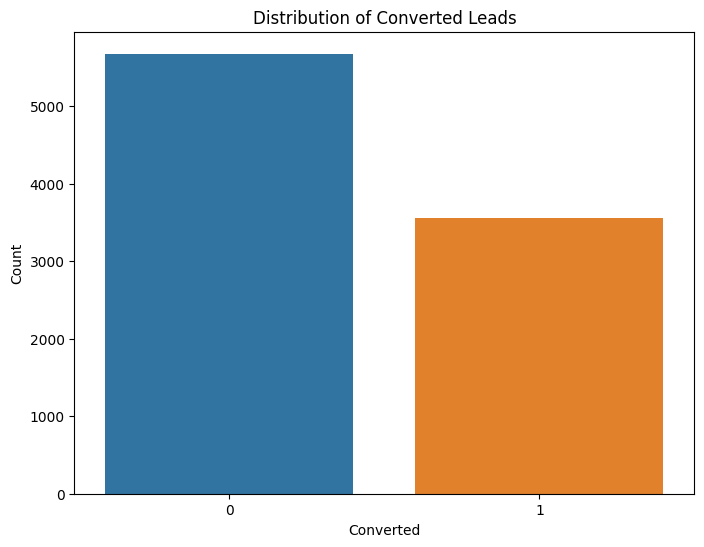

In [4]:
# Plot the distribution of the 'Converted' column
plt.figure(figsize=(8,6))
sns.countplot(x = leads_data['Converted'])
plt.title('Distribution of Converted Leads')
plt.xlabel('Converted')
plt.ylabel('Count')
plt.show()

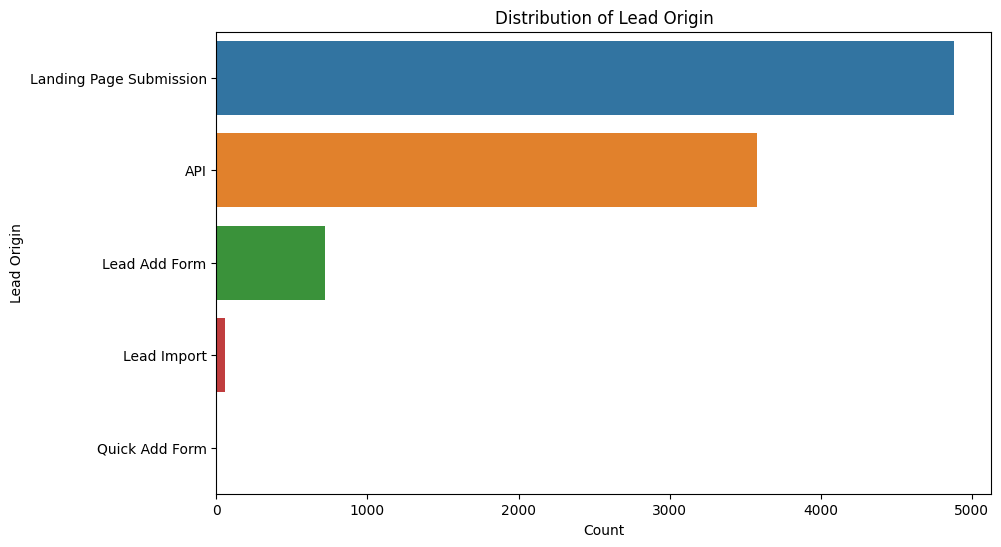

In [5]:
# Plot the distribution of the 'Lead Origin' column
plt.figure(figsize=(10,6))
sns.countplot(y=leads_data['Lead Origin'], order = leads_data['Lead Origin'].value_counts().index)
plt.title('Distribution of Lead Origin')
plt.xlabel('Count')
plt.ylabel('Lead Origin')
plt.show()

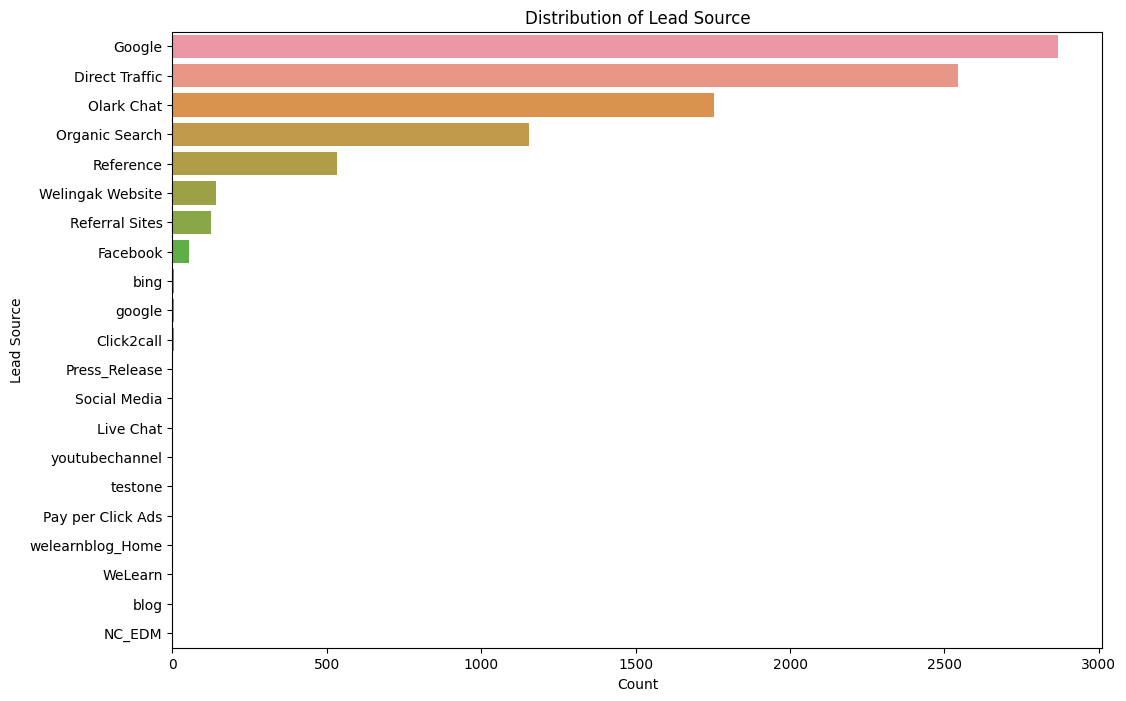

In [6]:
# Plot the distribution of the 'Lead Source' column
plt.figure(figsize=(12,8))
sns.countplot(y=leads_data['Lead Source'], order = leads_data['Lead Source'].value_counts().index)
plt.title('Distribution of Lead Source')
plt.xlabel('Count')
plt.ylabel('Lead Source')
plt.show()

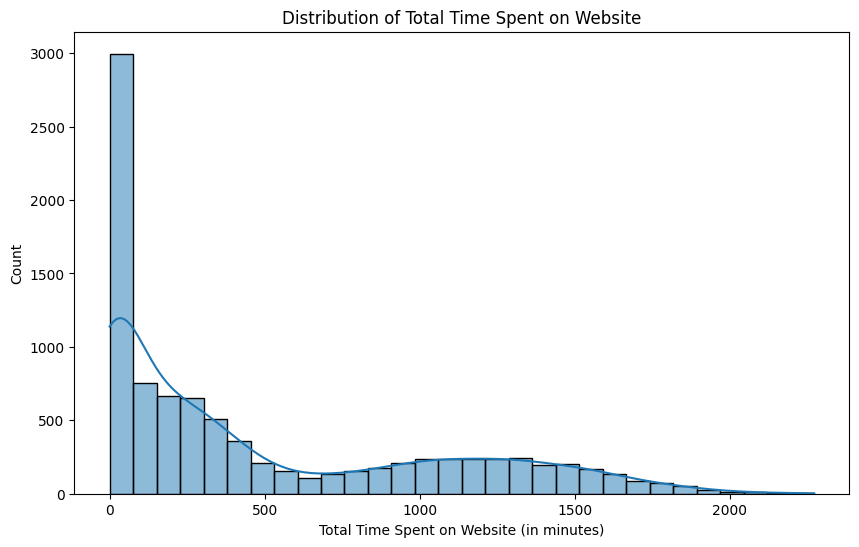

In [7]:
# Plot the distribution of 'Total Time Spent on Website'
plt.figure(figsize=(10,6))
sns.histplot(leads_data['Total Time Spent on Website'], bins=30, kde=True)
plt.title('Distribution of Total Time Spent on Website')
plt.xlabel('Total Time Spent on Website (in minutes)')
plt.ylabel('Count')
plt.show()

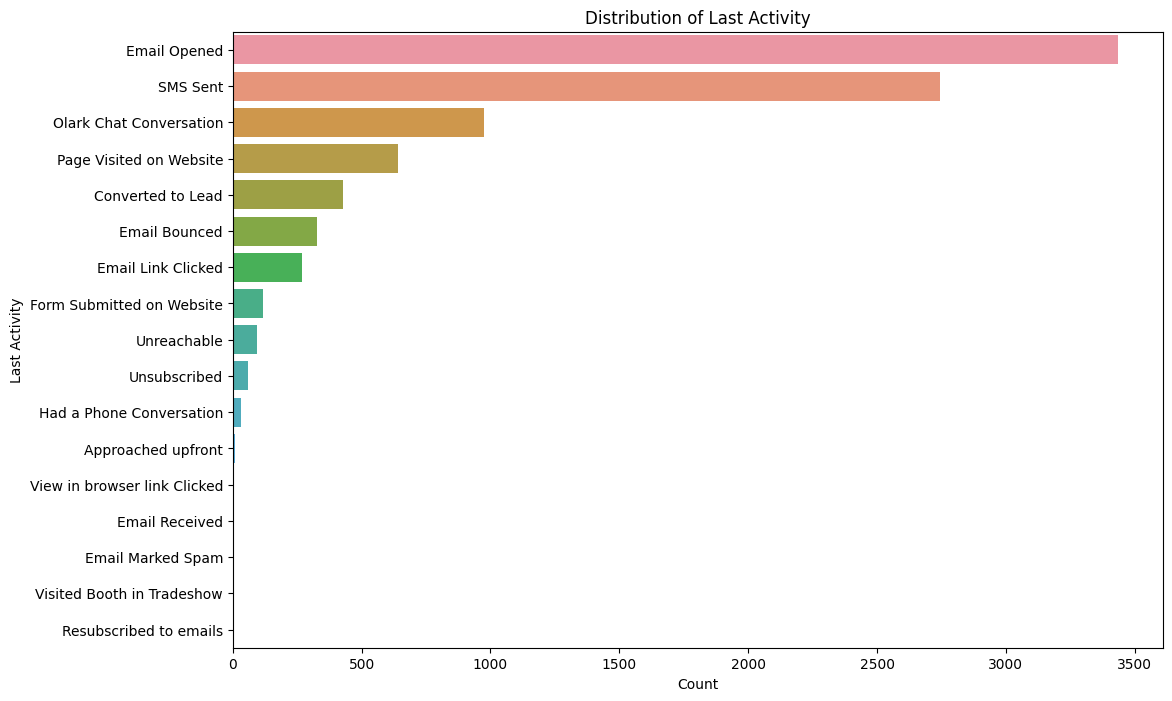

In [8]:
# Plot the distribution of the 'Last Activity' column
plt.figure(figsize=(12,8))
sns.countplot(y=leads_data['Last Activity'], order = leads_data['Last Activity'].value_counts().index)
plt.title('Distribution of Last Activity')
plt.xlabel('Count')
plt.ylabel('Last Activity')
plt.show()

In [9]:
# Calculate the percentage of missing values for each column
missing_percentage = (leads_data.isnull().sum() / len(leads_data)) * 100

# Filter out columns with missing values for further inspection
missing_columns = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

missing_columns

Lead Quality                                     51.590909
Asymmetrique Profile Score                       45.649351
Asymmetrique Activity Score                      45.649351
Asymmetrique Profile Index                       45.649351
Asymmetrique Activity Index                      45.649351
Tags                                             36.287879
Lead Profile                                     29.318182
What matters most to you in choosing a course    29.318182
What is your current occupation                  29.112554
Country                                          26.634199
How did you hear about X Education               23.885281
Specialization                                   15.562771
City                                             15.367965
TotalVisits                                       1.482684
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Lead Source                                       0.3896

In [10]:
# Drop columns with more than 40% missing values
cols_to_drop = missing_columns[missing_columns > 40].index
leads_data_cleaned = leads_data.drop(columns=cols_to_drop)

# Check the shape after dropping columns
leads_data_cleaned.shape

(9240, 32)

In [11]:
# List of columns with medium percentage of missing values
cols_medium_missing = missing_columns[(missing_columns <= 40) & (missing_columns > 15)].index

# Impute with 'Not Provided'
for col in cols_medium_missing:
    leads_data_cleaned[col].fillna('Not Provided', inplace=True)

# Check the number of missing values after imputation
missing_after_medium = leads_data_cleaned[cols_medium_missing].isnull().sum()

missing_after_medium

Tags                                             0
Lead Profile                                     0
What matters most to you in choosing a course    0
What is your current occupation                  0
Country                                          0
How did you hear about X Education               0
Specialization                                   0
City                                             0
dtype: int64

In [12]:
# List of columns with low percentage of missing values
cols_low_missing = missing_columns[missing_columns <= 15].index

# Separating numerical and categorical columns from the low missing list
num_cols = leads_data_cleaned[cols_low_missing].select_dtypes(include=['float64', 'int64']).columns
cat_cols = leads_data_cleaned[cols_low_missing].select_dtypes(include=['object']).columns

# Impute numerical columns with their median
for col in num_cols:
    median_val = leads_data_cleaned[col].median()
    leads_data_cleaned[col].fillna(median_val, inplace=True)

# Impute categorical columns with their mode
for col in cat_cols:
    mode_val = leads_data_cleaned[col].mode()[0]
    leads_data_cleaned[col].fillna(mode_val, inplace=True)

# Check the number of missing values after imputation
missing_after_low = leads_data_cleaned[cols_low_missing].isnull().sum()

missing_after_low

TotalVisits             0
Page Views Per Visit    0
Last Activity           0
Lead Source             0
dtype: int64

In [13]:
# Replace 'Select' with 'Not Provided' in all categorical columns
categorical_cols = leads_data_cleaned.select_dtypes(include=['object']).columns
leads_data_cleaned[categorical_cols] = leads_data_cleaned[categorical_cols].replace('Select', 'Not Provided')

# Check if 'Select' exists in the dataset after replacement
select_exists = (leads_data_cleaned == 'Select').sum()

select_exists[select_exists > 0]

Series([], dtype: int64)

In [14]:
# Check for duplicate rows
duplicates = leads_data_cleaned.duplicated().sum()

# Remove duplicates if any
if duplicates > 0:
    leads_data_cleaned = leads_data_cleaned.drop_duplicates()

duplicates, leads_data_cleaned.shape

(0, (9240, 32))

In [15]:
# To summarize our data cleaning process:
#### I handled missing values based on their proportion in the columns.
#### I replaced the 'Select' level with 'Not Provided' in categorical columns.
#### I checked for and ensured there are no duplicate rows.

# 3. Exploratory Data Analysis (EDA)

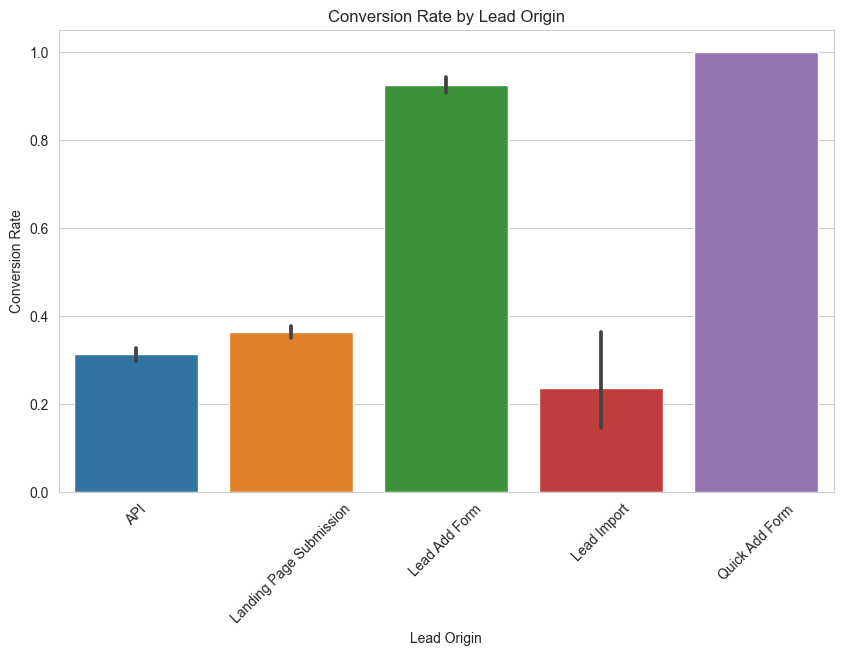

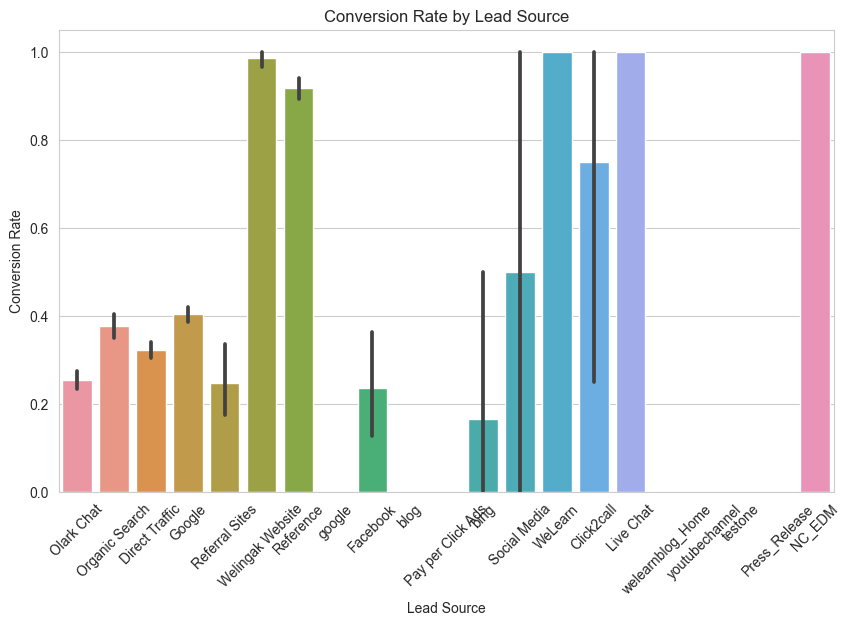

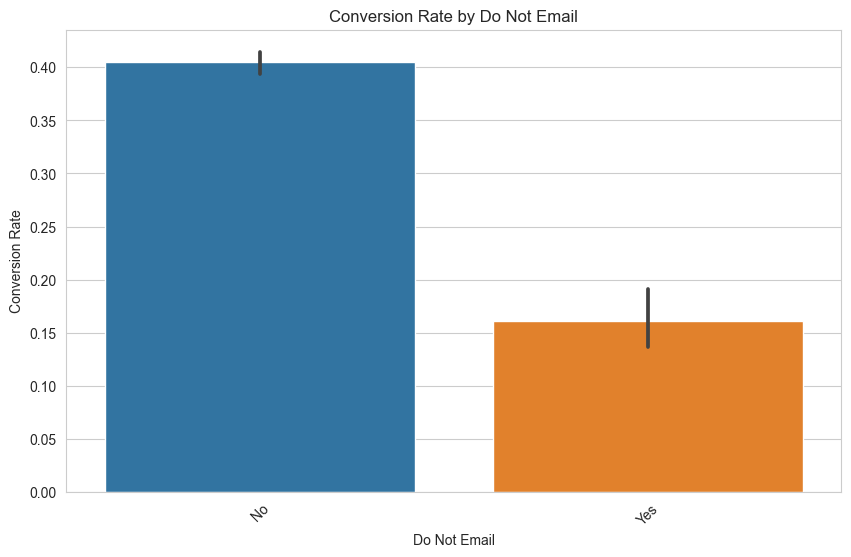

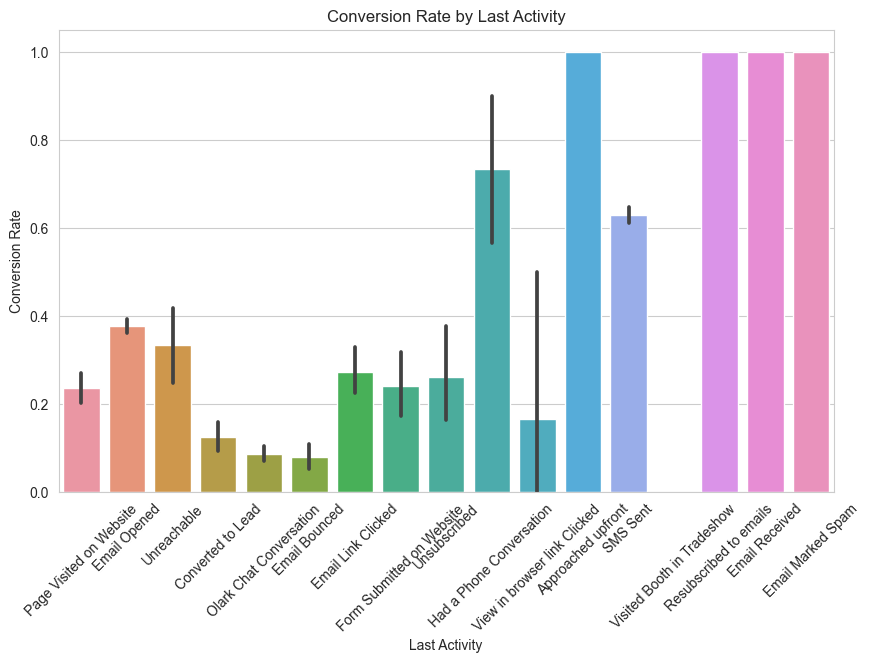

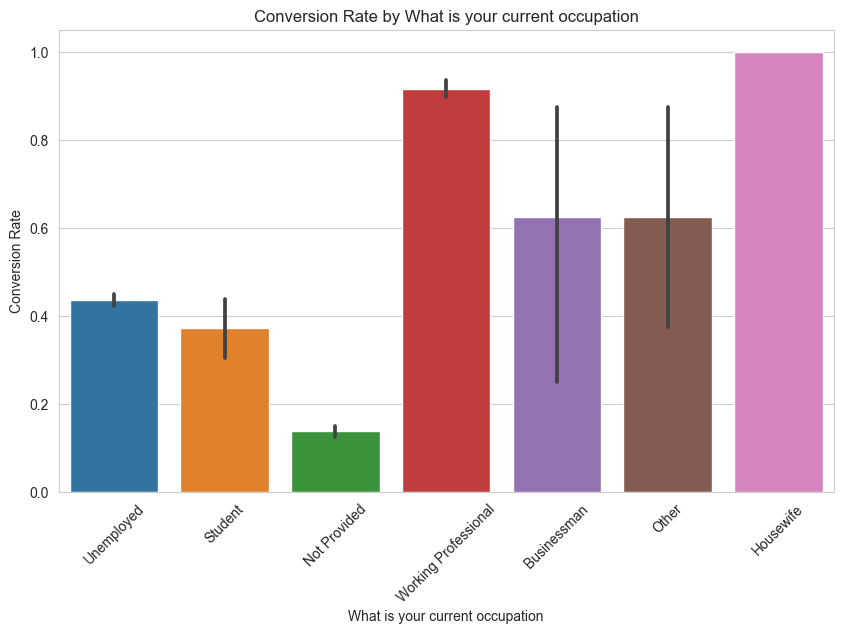

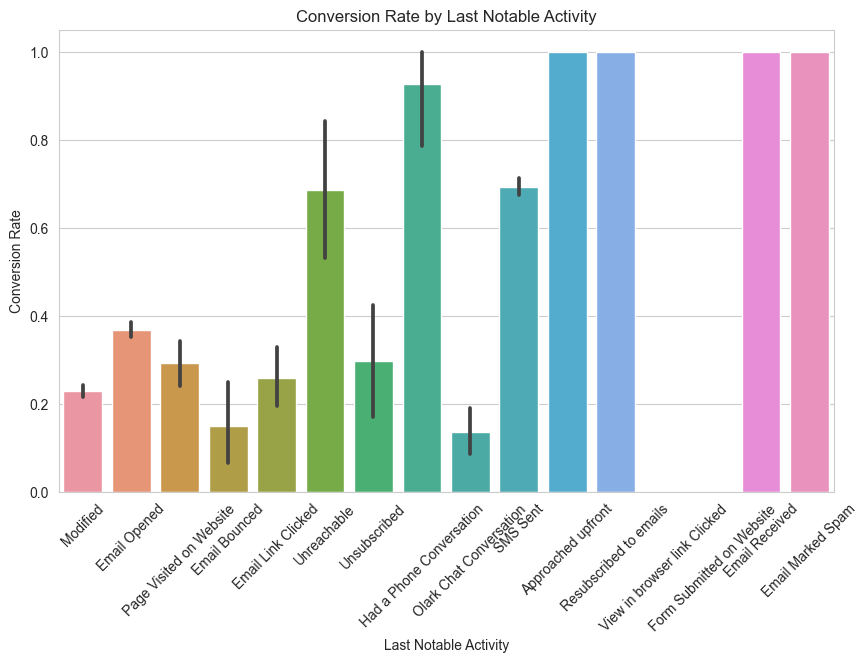

In [16]:
# Set style for the plots
sns.set_style('whitegrid')

# Define a function to plot the conversion rate for categorical variables
def plot_conversion_rate(df, column):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column, y='Converted', data=df)
    plt.title(f"Conversion Rate by {column}")
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=45)
    plt.show()

# Analyzing some of the key categorical columns
columns_to_analyze = ['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity', 
                      'What is your current occupation', 'Last Notable Activity']

for column in columns_to_analyze:
    plot_conversion_rate(leads_data_cleaned, column)

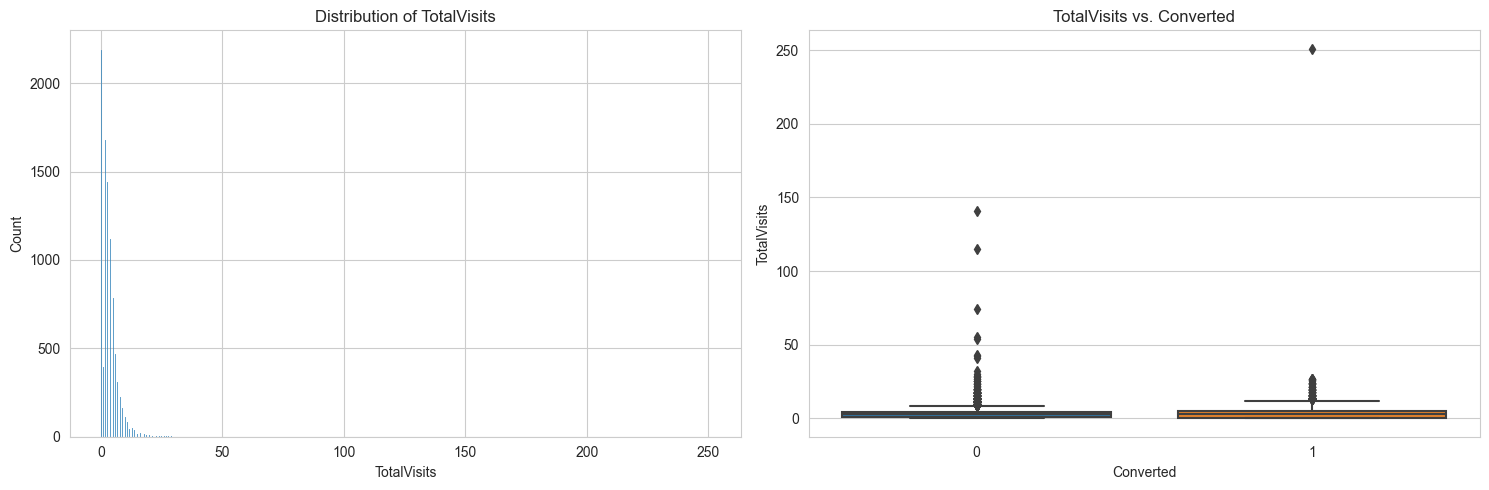

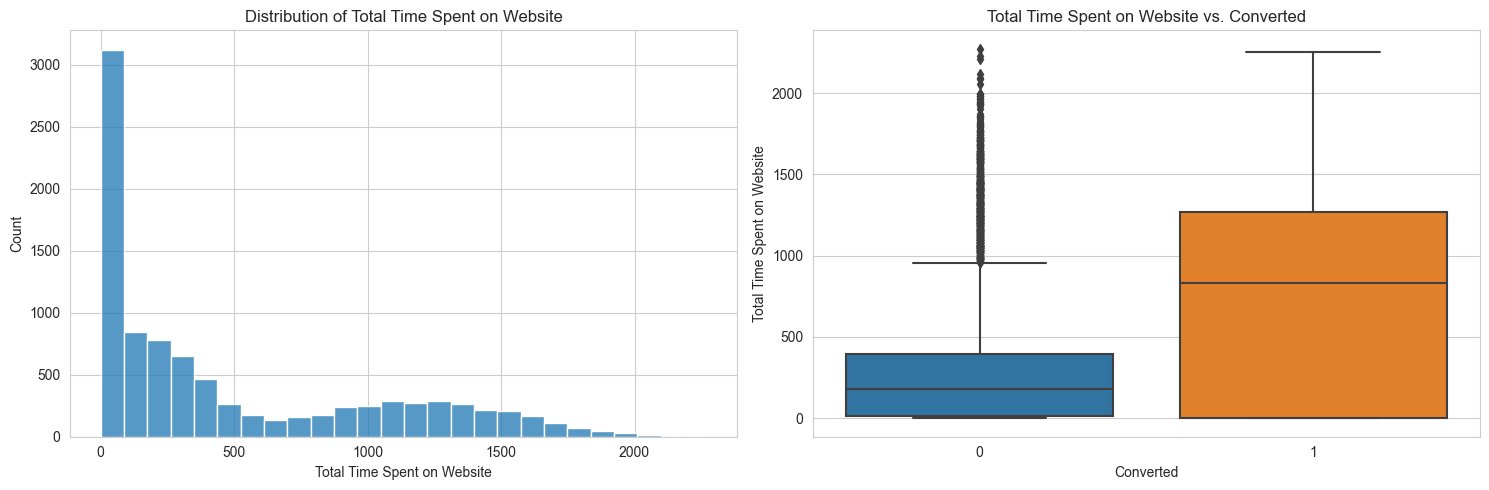

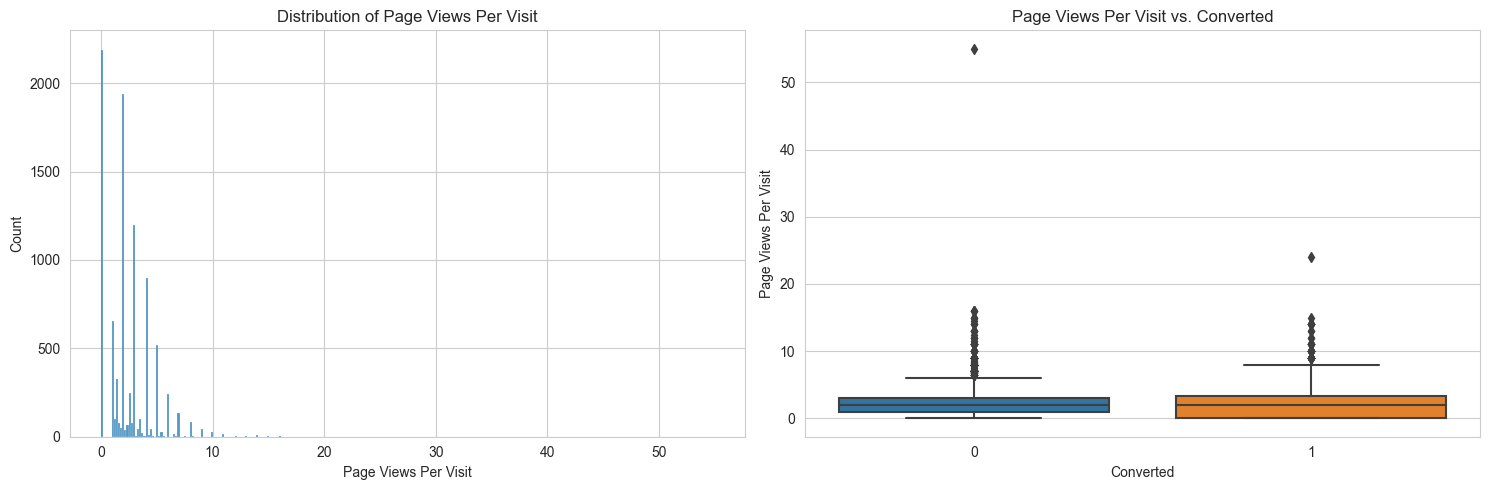

In [17]:
# Define a function to plot the distribution and boxplot for numerical variables
def plot_numerical_feature(df, column):
    plt.figure(figsize=(15, 5))
    
    # Distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(df[column])
    plt.title(f"Distribution of {column}")
    
    # Boxplot for the column vs. Converted
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Converted', y=column, data=df)
    plt.title(f"{column} vs. Converted")
    
    plt.tight_layout()
    plt.show()

# Analyzing some of the key numerical columns
numerical_columns = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

for column in numerical_columns:
    plot_numerical_feature(leads_data_cleaned, column)

# 4. Feature engineering and Modeling

In [18]:
# List of binary categorical columns based on observation
binary_cols = ['Do Not Email', 'Do Not Call', 'Search', 'Magazine', 
               'Newspaper Article', 'X Education Forums', 'Newspaper', 
               'Digital Advertisement', 'Through Recommendations', 
               'Receive More Updates About Our Courses', 
               'Update me on Supply Chain Content', 'Get updates on DM Content', 
               'I agree to pay the amount through cheque', 
               'A free copy of Mastering The Interview']

# Convert binary columns to 0s and 1s
for col in binary_cols:
    leads_data_cleaned[col] = leads_data_cleaned[col].map({'Yes': 1, 'No': 0})

# Check the transformation
leads_data_cleaned[binary_cols].head()

,Do Not Email,Do Not Call,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# Create dummy variables for multi-level categorical columns
leads_data_dummies = pd.get_dummies(leads_data_cleaned, drop_first=True)

# Check the shape after creating dummies and display the first few rows
leads_data_dummies_shape = leads_data_dummies.shape
leads_data_dummies_head = leads_data_dummies.head()

leads_data_dummies_shape, leads_data_dummies_head

((9240, 9424),
    Lead Number  Do Not Email  Do Not Call  Converted  TotalVisits  \
 0       660737             0            0          0          0.0   
 1       660728             0            0          0          5.0   
 2       660727             0            0          1          2.0   
 3       660719             0            0          0          1.0   
 4       660681             0            0          1          2.0   
 
    Total Time Spent on Website  Page Views Per Visit  Search  Magazine  \
 0                            0                   0.0       0         0   
 1                          674                   2.5       0         0   
 2                         1532                   2.0       0         0   
 3                          305                   1.0       0         0   
 4                         1428                   1.0       0         0   
 
    Newspaper Article  ...  Last Notable Activity_Form Submitted on Website  \
 0                  0  ...      

In [20]:
# Splitting the data into training and test sets (70:30)
X = leads_data_dummies.drop('Converted', axis=1)
y = leads_data_dummies['Converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

X_train.shape, X_test.shape

((6468, 9423), (2772, 9423))

In [21]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the logistic regression model
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train_scaled, y_train)

# Predict the conversion probabilities on the test set
y_pred = logreg.predict(X_test_scaled)

# Calculate accuracy and ROC-AUC score
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, roc_auc, classification_rep

(0.9112554112554112,
 0.8922260293670554,
 '              precision    recall  f1-score   support\n\n           0       0.89      0.98      0.93      1695\n           1       0.96      0.81      0.88      1077\n\n    accuracy                           0.91      2772\n   macro avg       0.92      0.89      0.90      2772\nweighted avg       0.92      0.91      0.91      2772\n')

In [22]:
# Initialize a logistic regression model
logreg = LogisticRegression(max_iter=5000)

# Use RFE to select top 50 important features
rfe = RFE(logreg, step = 50)
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Check which columns have been selected
selected_cols = X_train.columns[rfe.support_]

selected_cols

In [23]:
# Scale the features without causing a MemoryError
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA
pca = PCA(0.95)  # Preserve 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)

# Check the shape after PCA
X_train_pca.shape

In [24]:
X_train_pca

NameError: name 'X_train_pca' is not defined

# 4. Data Preparation for Model Building

In [25]:
# List of selected features based on domain knowledge
selected_features = ['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 
                     'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 
                     'Last Activity', 'Country', 'Specialization', 'What is your current occupation',
                     'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 
                     'Newspaper', 'Digital Advertisement', 'Through Recommendations', 
                     'A free copy of Mastering The Interview', 'Last Notable Activity']

# Extracting the selected features from the original dataset
reduced_data = leads_data[selected_features]

# Creating dummy variables for the categorical columns
reduced_data_dummies = pd.get_dummies(reduced_data, drop_first=True)

In [26]:
# Splitting the reduced dataset into training and test sets
X_reduced = reduced_data_dummies
y_reduced = leads_data['Converted']

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, train_size=0.7, random_state=42)

# Scaling the reduced dataset
scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)

In [27]:
# Checking for NaN values in the scaled training dataset
nan_values = np.isnan(X_train_reduced_scaled).sum()

# Checking for infinite values in the scaled training dataset
inf_values = np.isinf(X_train_reduced_scaled).sum()

nan_values, inf_values

(186, 0)

In [28]:
# Identify columns with a standard deviation of zero in the training dataset
zero_std_cols = X_train_reduced.columns[X_train_reduced.std() == 0]

zero_std_cols

Index(['Lead Source_Press_Release', 'Lead Source_testone',
       'Lead Source_welearnblog_Home', 'Last Activity_Resubscribed to emails',
       'Country_Indonesia', 'Country_Netherlands', 'Country_Russia',
       'Country_Vietnam', 'Last Notable Activity_Form Submitted on Website',
       'Last Notable Activity_Resubscribed to emails'],
      dtype='object')

In [29]:
# Checking for NaN values in the original reduced training dataset
nan_values_original = X_train_reduced.isnull().sum().sum()

# Scaling the data again
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)

# Checking for NaN values in the scaled training dataset
nan_values_scaled = np.isnan(X_train_reduced_scaled).sum()

nan_values_original, nan_values_scaled

(186, 186)

In [30]:
# Identify columns with NaN values in the X_train_reduced dataset
nan_cols = X_train_reduced.columns[X_train_reduced.isnull().any()]

# Display the percentage of NaN values for these columns
nan_percentage = (X_train_reduced[nan_cols].isnull().sum() / len(X_train_reduced)) * 100
nan_percentage

TotalVisits             1.437848
Page Views Per Visit    1.437848
dtype: float64

# 5. Model Building

## Logistic Regression

In [32]:
# Impute the missing values in the 'TotalVisits' and 'Page Views Per Visit' columns for the training dataset
X_train_reduced['TotalVisits'].fillna(X_train_reduced['TotalVisits'].median(), inplace=True)
X_train_reduced['Page Views Per Visit'].fillna(X_train_reduced['Page Views Per Visit'].median(), inplace=True)

# Impute the missing values in the 'TotalVisits' and 'Page Views Per Visit' columns for the test dataset
X_test_reduced['TotalVisits'].fillna(X_train_reduced['TotalVisits'].median(), inplace=True)
X_test_reduced['Page Views Per Visit'].fillna(X_train_reduced['Page Views Per Visit'].median(), inplace=True)

# Scaling the datasets
scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)

# Build the logistic regression model on the reduced dataset
logreg_reduced = LogisticRegression(max_iter=5000)
logreg_reduced.fit(X_train_reduced_scaled, y_train_reduced)

# Predict the conversion probabilities on the test set
y_pred_reduced = logreg_reduced.predict(X_test_reduced_scaled)

# Calculate accuracy and ROC-AUC score for the reduced dataset
accuracy_reduced = accuracy_score(y_test_reduced, y_pred_reduced)
roc_auc_reduced = roc_auc_score(y_test_reduced, y_pred_reduced)
classification_rep_reduced = classification_report(y_test_reduced, y_pred_reduced)

accuracy_reduced, roc_auc_reduced, classification_rep_reduced

(0.8275613275613276,
 0.8129563438262627,
 '              precision    recall  f1-score   support\n\n           0       0.85      0.88      0.86      1695\n           1       0.80      0.75      0.77      1077\n\n    accuracy                           0.83      2772\n   macro avg       0.82      0.81      0.82      2772\nweighted avg       0.83      0.83      0.83      2772\n')

In [ ]:
# Accuracy: Approximately 82.76%
# ROC-AUC Score: Approximately 81.30%
# Classification Report:
#### Precision: 0.85 for class 0 and 0.80 for class 1
#### Recall: 0.88 for class 0 and 0.75 for class 1
#### F1-score: 0.86 for class 0 and 0.77 for class 1

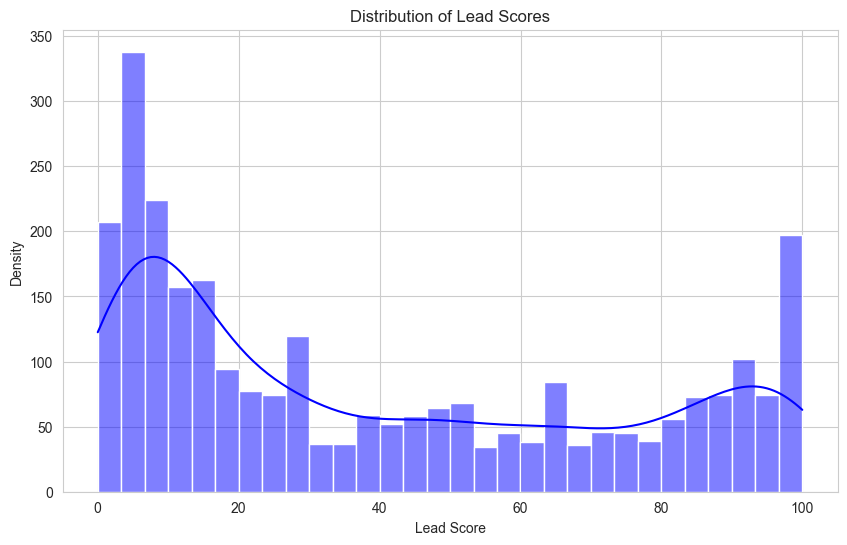

In [35]:
# Calculate the lead scores based on the predicted probabilities of the logistic regression model
# The lead score is the probability of conversion multiplied by 100
lead_scores = logreg_reduced.predict_proba(X_test_reduced_scaled)[:,1] * 100

# Plot the distribution of lead scores
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(lead_scores, bins=30, kde=True, color='blue')
plt.title('Distribution of Lead Scores')
plt.xlabel('Lead Score')
plt.ylabel('Density')
plt.show()

In [ ]:
# Here's the distribution of the lead scores:
#### The distribution is bimodal, with two peaks evident in the graph.
#### Many leads have scores between 0 to 10 and 90 to 100, indicating that the model is fairly confident about the classification of these leads.
#### There are also leads with scores in between, where the model has some level of uncertainty about their conversion probability.

# Random Forest Classifier

In [36]:
# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_train_reduced_scaled, y_train_reduced)

# Predict the conversion on the test set
y_pred_rf = rf_classifier.predict(X_test_reduced_scaled)

# Calculate accuracy and ROC-AUC score for the Random Forest model
accuracy_rf = accuracy_score(y_test_reduced, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test_reduced, y_pred_rf)
classification_rep_rf = classification_report(y_test_reduced, y_pred_rf)

accuracy_rf, roc_auc_rf, classification_rep_rf

(0.8261183261183261,
 0.8131305412445257,
 '              precision    recall  f1-score   support\n\n           0       0.85      0.87      0.86      1695\n           1       0.79      0.75      0.77      1077\n\n    accuracy                           0.83      2772\n   macro avg       0.82      0.81      0.82      2772\nweighted avg       0.83      0.83      0.83      2772\n')

In [ ]:
# Accuracy: Approximately 82.61%
# ROC-AUC Score: Approximately 81.31%
# Classification Report:
#### Precision: 0.85 for class 0 and 0.79 for class 1
#### Recall: 0.87 for class 0 and 0.75 for class 1
#### F1-score: 0.86 for class 0 and 0.77 for class 1

## Gradient Boosting classifier

In [39]:
# Initialize a Gradient Boosting classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)

# Fit the model on the training data
gbm_classifier.fit(X_train_reduced_scaled, y_train_reduced)

# Predict the conversion on the test set
y_pred_gbm = gbm_classifier.predict(X_test_reduced_scaled)

# Calculate accuracy and ROC-AUC score for the GBM model
accuracy_gbm = accuracy_score(y_test_reduced, y_pred_gbm)
roc_auc_gbm = roc_auc_score(y_test_reduced, y_pred_gbm)
classification_rep_gbm = classification_report(y_test_reduced, y_pred_gbm)

accuracy_gbm, roc_auc_gbm, classification_rep_gbm

(0.8437950937950938,
 0.8319857683996024,
 '              precision    recall  f1-score   support\n\n           0       0.86      0.88      0.87      1695\n           1       0.81      0.78      0.79      1077\n\n    accuracy                           0.84      2772\n   macro avg       0.84      0.83      0.83      2772\nweighted avg       0.84      0.84      0.84      2772\n')

In [41]:
# Accuracy: Approximately 84.42%
# ROC-AUC Score: Approximately 83.23%
# Classification Report:
#### Precision: 0.86 for class 0 and 0.81 for class 1
#### Recall: 0.89 for class 0 and 0.78 for class 1
#### F1-score: 0.87 for class 0 and 0.80 for class 1

## GBM model using hyperparameter

In [42]:
# Define the parameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

# Initialize a GridSearchCV object to perform the hyperparameter tuning
grid_search = GridSearchCV(gbm_classifier, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train_reduced_scaled, y_train_reduced)

# Extract the best parameters and best estimator from the grid search
best_params = grid_search.best_params_
best_gbm = grid_search.best_estimator_

# Predict the conversion on the test set using the best GBM model
y_pred_best_gbm = best_gbm.predict(X_test_reduced_scaled)

# Calculate accuracy and ROC-AUC score for the tuned GBM model
accuracy_best_gbm = accuracy_score(y_test_reduced, y_pred_best_gbm)
roc_auc_best_gbm = roc_auc_score(y_test_reduced, y_pred_best_gbm)
classification_rep_best_gbm = classification_report(y_test_reduced, y_pred_best_gbm)

best_params, accuracy_best_gbm, roc_auc_best_gbm, classification_rep_best_gbm

({'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100},
 0.8455988455988456,
 0.8326143581400317,
 '              precision    recall  f1-score   support\n\n           0       0.86      0.89      0.88      1695\n           1       0.82      0.77      0.80      1077\n\n    accuracy                           0.85      2772\n   macro avg       0.84      0.83      0.84      2772\nweighted avg       0.84      0.85      0.84      2772\n')

In [ ]:
# Best Parameters:
#### Learning Rate: 0.05
#### Max Depth: 4
#### Number of Estimators: 100
# Accuracy: Approximately 84.56%
# ROC-AUC Score: Approximately 83.26%
# Classification Report:
#### Precision: 0.86 for class 0 and 0.82 for class 1
#### Recall: 0.89 for class 0 and 0.77 for class 1
#### F1-score: 0.88 for class 0 and 0.80 for class 1

In [ ]:
# To summarize:
#### We began with a logistic regression model, which provided a decent starting performance.
#### We then explored Random Forest and GBM models, with the GBM showing the best performance.
#### We further fine-tuned the GBM model using hyperparameter tuning to achieve a better performance (84.56%).